# GEOtiled Demo: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters

The GEOtiled workflow is comprised of three stages: 
1. Reproject and partition a Digital Elevation Model (DEM) into tiles, each with a buffer region
2. Compute the terrain parameters for each individual tile concurrently
3. Mosaic each parameter's tiles together

<p style="text-align:center">
    <img src="demo_images/workflow.png" width="500"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>GEOtiled Workflow
</p>
    
Terrain parameters are computed using DEMs from [USGS 3DEP Products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services) to compute 3 topographic parameters: aspect, hillshade, and slope. By default, this demo uses 3DEP products covering the entirety of the US state of Tennessee at a 30m resolution.

If you would like to work with a different region of data, go to the [USGS Data Download Application](https://apps.nationalmap.gov/downloader/#/elevation) and use the map to look for available DEM data. Data should be downloaded using the TXT button located under the *Products* tab, and the text file should be stored in your working directory.

**IMPORTANT NOTE: Larger regions or higher resolutions will significantly increase the size of the data and the time to compute it.** 

## Environment Setup

The first cell below imports required libraries to run the notebook.

In [1]:
# DO NOT MODIFY: Import libraries used to run notebook
import geotiled

geotiled.gdal.UseExceptions() # Used to silence a deprecation warning. 

### Settings

In the following cell you may specify variables such as what data to download, the number of intermediary tiles to use for computation, and the file path where data will be stored. Comments for what each variable is for is included.

**Important Notes**
* For DEM download, three different methods are available: from a text file with a list of USGS download links, based off a shape file, or a specified latitude and longitude box
  * A text file from the USGS page should be stored in the working directory or child directory
  * Shape files are available for all US states and Washington DC. For the shapefile variable, specify the state abbreviation to use the correlating shapefile (e.g. TN for Tennessee)
  * A bounding box can be specified using the following syntax: {"xmin": val,"ymin": val,"xmax": val,"ymax": val}. X values correlate to longitude and Y values correlate to latitude

In [2]:
download_list = 'download_urls'                                         # Name of file to store DEM download URLs
bounding_box = {"xmin": -90.4,"ymin": 34.8,"xmax": -81.55,"ymax": 36.8} # Bounding box to use for DEM download
shape_file = 'TN'                                                       # Shape file to use for DEM download and image cropping
num_tiles = 16                                                          # Number of tiles to split the DEM mosaic into

data_folder = './geotiled_data/'                                        # Root folder where GEOtiled data will be stored
geotiled.set_data_directory(data_folder)                                # Sets the directory to store data in

## Pre-processing of the DEM

### Fetch Data

`fetch_dem()` pulls DEM data directly from the USGS webpage with a specified shape file or bounding box and a desired dataset. It will return a text file with the download URLs which can be saved or immediately downloaded from. **Note that if both a shape file and bounding box are given, the shape file will take precedent.**

`download_files()` downloads the DEMs from a supplied text file with URLs or a Python list of strings containing the URLs. If you would like to use your own text file to download DEMs, skip `fetch_dem()` and only run this function.

In [3]:
# Create a text file with download URLs from a shape file
geotiled.fetch_dem(bbox=bounding_box, txt_file=download_list, dataset="30m")

# Download files from the created text file
geotiled.download_files(download_list, 'dem_tiles')

Setting boundary extents...
Requesting data from USGS...
Saving URLs to text file...
Fetch process complete.


Downloading: 100%|██████████████████████████████████████████████| 1.72G/1.72G [00:14<00:00, 119MB/s]


### Mosaic and Reproject DEMs

`build_mosaic` creates a mosaic from a list of GeoTIFF files.

`reproject` reprojects a specified GeoTIFF raster dataset from its original coordinate system to a new specified projection. DEMs from USGS are projected using the Global Coordinate System (GCS) by default.

In [5]:
# Build mosaic from DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic', description='Elevation', cleanup=True)

# Reproject the mosaic to Projected Coordinate System (PCS) EPSG:9822 - Albers Conic Equal Area projection 
geotiled.reproject(input_file='mosaic', output_file='elevation', projection='EPSG:9822', cleanup=True)

Getting input files...
Constructing VRT...
Updating band description...
Cleaning intermediary files...
Mosaic process complete.
Reprojecting mosaic.tif...
Cleaning intermediary files...
Reprojection process complete.


## Compute Parameters with GEOtiled

`crop_into_tiles()` splits a GeoTIFF file into a specified number of tiles.

`compute_geotiled()` concurrently computes terrain parameters slope, aspect, and hillshading for all provided elevation model files.

`build_mosaic_filtered()` is similar to `build_mosaic()` but includes extra logic to handle averaging of buffer regions made from cropping the mosaic.

In [6]:
# Crop reprojected mosaic into specified number of intermediary elevation tiles
geotiled.crop_into_tiles(input_file='elevation', output_folder='elevation_tiles', num_tiles=num_tiles)

tile_0000.tif cropped.
tile_0001.tif cropped.
tile_0002.tif cropped.
tile_0003.tif cropped.
tile_0004.tif cropped.
tile_0005.tif cropped.
tile_0006.tif cropped.
tile_0007.tif cropped.
tile_0008.tif cropped.
tile_0009.tif cropped.
tile_0010.tif cropped.
tile_0011.tif cropped.
tile_0012.tif cropped.
tile_0013.tif cropped.
tile_0014.tif cropped.
tile_0015.tif cropped.


In [7]:
# Run GEOtiled to compute all terrain parameters for each cropped tile
geotiled.compute_geotiled(input_folder='elevation_tiles', num_procs=num_tiles, cleanup=True)

Getting input files...
Starting computation of parameters...
All parameters for tile_0012.tif computed.
All parameters for tile_0003.tif computed.
All parameters for tile_0008.tif computed.
All parameters for tile_0007.tif computed.
All parameters for tile_0002.tif computed.
All parameters for tile_0013.tif computed.
All parameters for tile_0011.tif computed.
All parameters for tile_0004.tif computed.
All parameters for tile_0015.tif computed.
All parameters for tile_0000.tif computed.
All parameters for tile_0006.tif computed.
All parameters for tile_0009.tif computed.
All parameters for tile_0014.tif computed.
All parameters for tile_0001.tif computed.
All parameters for tile_0010.tif computed.
All parameters for tile_0005.tif computed.
Cleaning files...
GEOtiled computation completed.


In [8]:
# Build the mosaic for each of the terrain parameters
geotiled.build_mosaic_filtered(input_folder='aspect_tiles', output_file='aspect', cleanup=True)
geotiled.build_mosaic_filtered(input_folder='hillshade_tiles', output_file='hillshade', cleanup=True)
geotiled.build_mosaic_filtered(input_folder='slope_tiles', output_file='slope', cleanup=True)

Mosaicking started for aspect.tif...
Building VRT...
Averaging buffer values...
Cleaning files...
Mosaic process completed.
Mosaicking started for hillshade.tif...
Building VRT...
Averaging buffer values...
Cleaning files...
Mosaic process completed.
Mosaicking started for slope.tif...
Building VRT...
Averaging buffer values...
Cleaning files...
Mosaic process completed.


## Visualize the Results

`generate_img()` plots the GeoTIFF data. A wide variety of parameters are available for this function, and details on what each one does can be found in the function documentation.

Reprojecting elevation.tif...
Reprojection process complete.
Cropping NaN values...
Reading in tif for visualization...
Plotting data...
Done. Image should appear soon...
Reprojecting hillshade.tif...
Reprojection process complete.
Cropping NaN values...
Reading in tif for visualization...
Plotting data...
Done. Image should appear soon...
Reprojecting aspect.tif...
Reprojection process complete.
Cropping NaN values...
Reading in tif for visualization...
Plotting data...
Done. Image should appear soon...
Reprojecting slope.tif...
Reprojection process complete.
Cropping NaN values...
Reading in tif for visualization...
Plotting data...
Done. Image should appear soon...


masked_array(
  data=[[14.251569747924805, 8.781769752502441, 8.180298805236816, ...,
         7.8717827796936035, 20.15897560119629, 12.223953247070312],
        [11.632308006286621, 7.824007987976074, 8.967260360717773, ...,
         18.37828254699707, 13.434113502502441, 17.90743637084961],
        [16.088802337646484, 11.432670593261719, 12.92690372467041, ...,
         14.126882553100586, 10.858179092407227, 17.418901443481445],
        ...,
        [1.7257006168365479, 3.803586721420288, 3.4412612915039062, ...,
         0.8383139371871948, 0.9352452158927917, 1.3965576887130737],
        [0.6511538028717041, 0.7559522390365601, 0.6959972381591797, ...,
         0.9216864109039307, 0.6534585952758789, 0.7476351857185364],
        [2.0509719848632812, 0.34327253699302673, 0.4866398870944977,
         ..., 0.5534635782241821, 0.5704871416091919, 0.631744921207428]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
   

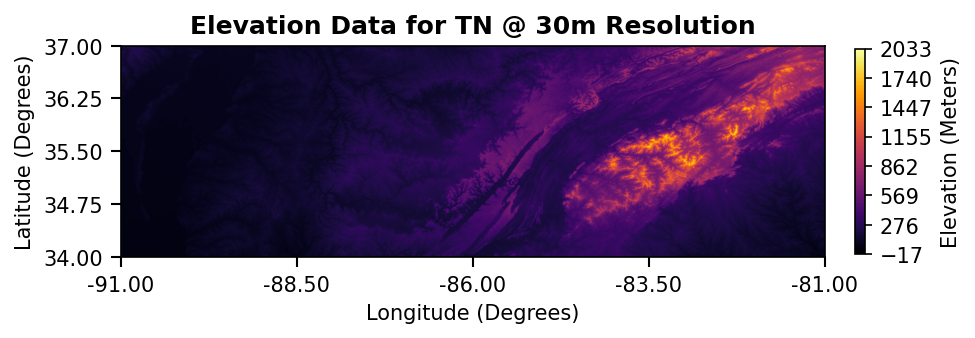

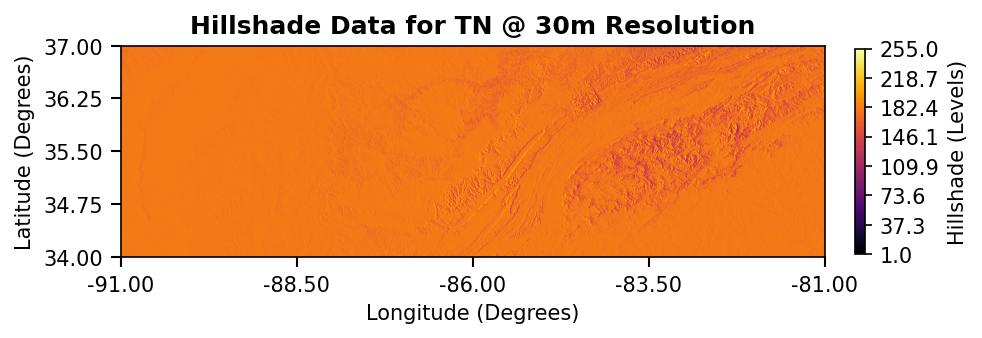

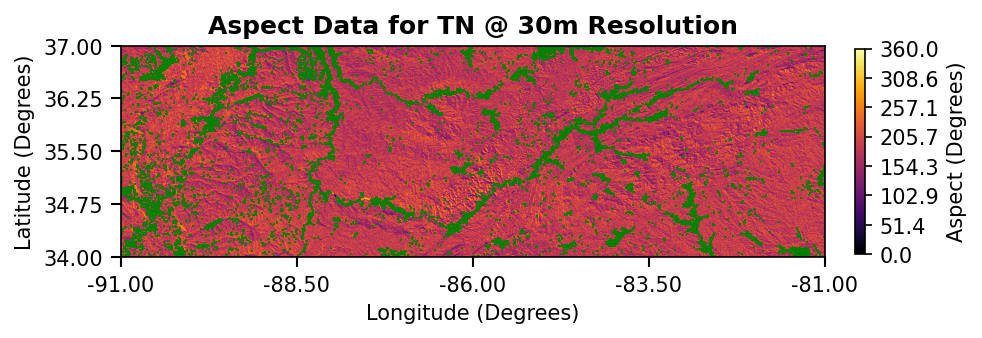

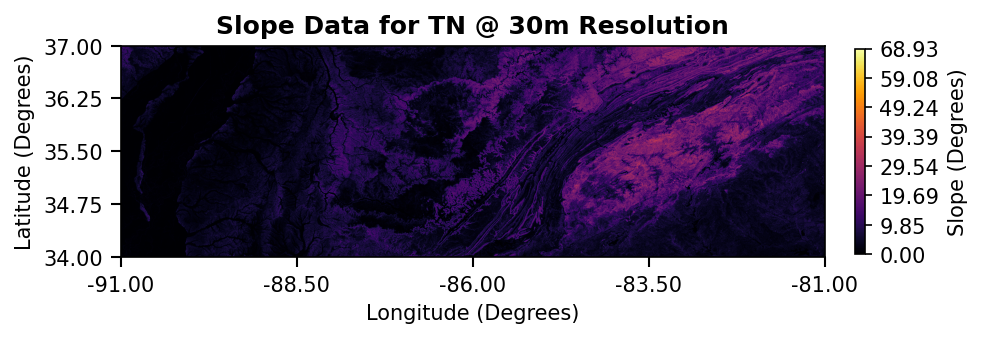

In [9]:
# Create plots for all terrain parameters
geotiled.generate_img(tif='elevation', downsample=5, reproject_gcs=True, title="Elevation Data for TN @ 30m Resolution", zunit="Meter",  xyunit="Degree", ztype="Elevation") 
geotiled.generate_img(tif='hillshade', downsample=5, reproject_gcs=True, title="Hillshade Data for TN @ 30m Resolution", zunit="Level",  xyunit="Degree", ztype="Hillshade")
geotiled.generate_img(tif='aspect',    downsample=5, reproject_gcs=True, title="Aspect Data for TN @ 30m Resolution",    zunit="Degree", xyunit="Degree", ztype="Aspect")
geotiled.generate_img(tif='slope',     downsample=5, reproject_gcs=True, title="Slope Data for TN @ 30m Resolution",     zunit="Degree", xyunit="Degree", ztype="Slope")

## End of Demo